## ====== PARTIE 1: IMPORTATIONS =======

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

##  === PARTIE 2: CHARGEMENT DES DONNÉES ====

In [157]:
print("Chargement des données...")
# Charger les données d'entraînement
train_df = pd.read_csv('train.csv')
print(f"Train shape: {train_df.shape}")

# Charger les données de test
test_df = pd.read_csv('test.csv')
print(f"Test shape: {test_df.shape}")
print("\n")

Chargement des données...
Train shape: (130, 33)
Test shape: (56, 32)




## ====== PARTIE 3: PRÉPARATION DES DONNÉES ======

In [158]:
print("Préparation des données...")

# Identifier les features et la cible
TARGET = 'HOMELESS_RATE'

# Features à exclure (ID et cible)
excluded_features = ['ID', TARGET]

# Features pour l'entraînement
features = [col for col in train_df.columns if col not in excluded_features]
print(f"Nombre de features: {len(features)}")
print(f"Features: {features}")

# Préparer les données d'entraînement
X_train = train_df[features]
y_train = train_df[TARGET]

# Préparer les données de test (sans la cible)
X_test = test_df[features]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print("\n")

Préparation des données...
Nombre de features: 31
Features: ['AGE_U18_PCT', 'AGE_18_24_PCT', 'AGE_25_34_PCT', 'AGE_35_44_PCT', 'AGE_45_54_PCT', 'AGE_55_59_PCT', 'AGE_60_61_PCT', 'AGE_62_64_PCT', 'AGE_65_69_PCT', 'AGE_70_79_PCT', 'AGE_80_PLUS_PCT', 'AGE_25_PLUS_PCT', 'FAMILY_MEMBERS_UNDER_18_PCT', 'RACE_WHITE_NH_PCT', 'RACE_BLACK_NH_PCT', 'RACE_NATIVE_NH_PCT', 'RACE_ASIAN_NH_PCT', 'RACE_PACIFIC_NH_PCT', 'RACE_TWO_OR_MORE_NH_PCT', 'RACE_HISPANIC_ANY_PCT', 'VETERAN_POP_PCT', 'NONVETERAN_POP_PCT', 'DISABILITY_POP_PCT', 'NODISABILITY_POP_PCT', 'TOTAL_HOUSEHOLDS_PCT', 'FAMILY_HH_TOTAL', 'FAMILY_HH_CHILD_LT18_PCT', 'NONFAMILY_SINGLE_MALE_PCT', 'NONFAMILY_SINGLE_FEMALE_PCT', 'MULTI_PERSON_NONFAMILY_HH_PCT', 'INDIVIDUALS_NOT_IN_FAMILY_UNITS_PCT']
X_train shape: (130, 31)
y_train shape: (130,)
X_test shape: (56, 31)




## ====== PARTIE 4: PRÉTRAITEMENT =======

In [159]:
print("Prétraitement des données...")

# Standardisation des features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertir en DataFrame pour plus de clarté
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=features, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=features, index=X_test.index)

print("Standardisation terminée.")
print("\n")

Prétraitement des données...
Standardisation terminée.




## ==== PARTIE 5: DIVISION TRAIN/VALIDATION ====

In [160]:
print("Division des données en train/validation...")
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_scaled_df, y_train, test_size=0.2, random_state=42
)
print(f"Train split: {X_train_split.shape}")
print(f"Validation split: {X_val_split.shape}")
print("\n")

Division des données en train/validation...
Train split: (104, 31)
Validation split: (26, 31)




## ==== PARTIE 6: RÉGRESSION LINÉAIRE SIMPLE ====

In [161]:
print("=" * 50)
print("ENTRAÎNEMENT DU MODÈLE: RÉGRESSION LINÉAIRE")
print("=" * 50)

# Initialiser et entraîner le modèle
lr_model = LinearRegression()
lr_model.fit(X_train_split, y_train_split)

# Prédictions
y_train_pred_lr = lr_model.predict(X_train_split)
y_val_pred_lr = lr_model.predict(X_val_split)

# Évaluation
train_rmse_lr = np.sqrt(mean_squared_error(y_train_split, y_train_pred_lr))
val_rmse_lr = np.sqrt(mean_squared_error(y_val_split, y_val_pred_lr))
train_mae_lr = mean_absolute_error(y_train_split, y_train_pred_lr)
val_mae_lr = mean_absolute_error(y_val_split, y_val_pred_lr)
train_r2_lr = r2_score(y_train_split, y_train_pred_lr)
val_r2_lr = r2_score(y_val_split, y_val_pred_lr)

print(f"Linear Regression - Train RMSE: {train_rmse_lr:.4f}")
print(f"Linear Regression - Validation RMSE: {val_rmse_lr:.4f}")
print(f"Linear Regression - Train MAE: {train_mae_lr:.4f}")
print(f"Linear Regression - Validation MAE: {val_mae_lr:.4f}")
print(f"Linear Regression - Train R²: {train_r2_lr:.4f}")
print(f"Linear Regression - Validation R²: {val_r2_lr:.4f}")
print(f"Nombre de coefficients non-nuls: {np.sum(lr_model.coef_ != 0)}")
print("\n")

ENTRAÎNEMENT DU MODÈLE: RÉGRESSION LINÉAIRE
Linear Regression - Train RMSE: 0.0055
Linear Regression - Validation RMSE: 0.0052
Linear Regression - Train MAE: 0.0035
Linear Regression - Validation MAE: 0.0043
Linear Regression - Train R²: 0.4329
Linear Regression - Validation R²: -2.4414
Nombre de coefficients non-nuls: 31




## ==== PARTIE 7: RÉGRESSION RIDGE AVEC GRIDSEARCH ====

In [162]:
print("=" * 50)
print("ENTRAÎNEMENT DU MODÈLE: RIDGE REGRESSION (GridSearchCV)")
print("=" * 50)

# Définir la grille de paramètres pour Ridge
ridge_params = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

# Initialiser et entraîner avec GridSearchCV
ridge_model = Ridge(random_state=42)
ridge_grid = GridSearchCV(
    ridge_model, 
    ridge_params, 
    cv=5, 
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

print("Recherche des meilleurs paramètres pour Ridge...")
ridge_grid.fit(X_train_split, y_train_split)

# Meilleurs paramètres
print(f"Meilleur alpha pour Ridge: {ridge_grid.best_params_['alpha']}")
print(f"Meilleur score (négatif MSE): {ridge_grid.best_score_:.4f}")

# Meilleur modèle
best_ridge = ridge_grid.best_estimator_

# Prédictions avec le meilleur modèle
y_train_pred_ridge = best_ridge.predict(X_train_split)
y_val_pred_ridge = best_ridge.predict(X_val_split)

# Évaluation
train_rmse_ridge = np.sqrt(mean_squared_error(y_train_split, y_train_pred_ridge))
val_rmse_ridge = np.sqrt(mean_squared_error(y_val_split, y_val_pred_ridge))
train_r2_ridge = r2_score(y_train_split, y_train_pred_ridge)
val_r2_ridge = r2_score(y_val_split, y_val_pred_ridge)

print(f"Ridge Regression - Train RMSE: {train_rmse_ridge:.4f}")
print(f"Ridge Regression - Validation RMSE: {val_rmse_ridge:.4f}")
print(f"Ridge Regression - Train R²: {train_r2_ridge:.4f}")
print(f"Ridge Regression - Validation R²: {val_r2_ridge:.4f}")
print(f"Nombre de coefficients non-nuls: {np.sum(best_ridge.coef_ != 0)}")
print("\n")

ENTRAÎNEMENT DU MODÈLE: RIDGE REGRESSION (GridSearchCV)
Recherche des meilleurs paramètres pour Ridge...
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Meilleur alpha pour Ridge: 1000
Meilleur score (négatif MSE): -0.0001
Ridge Regression - Train RMSE: 0.0066
Ridge Regression - Validation RMSE: 0.0030
Ridge Regression - Train R²: 0.1694
Ridge Regression - Validation R²: -0.1416
Nombre de coefficients non-nuls: 31




## ==== PARTIE 8: RÉGRESSION LASSO AVEC GRIDSEARCH ====

In [163]:
print("=" * 50)
print("ENTRAÎNEMENT DU MODÈLE: LASSO REGRESSION (GridSearchCV)")
print("=" * 50)

# Définir la grille de paramètres pour Lasso
lasso_params = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
}

# Initialiser et entraîner avec GridSearchCV
lasso_model = Lasso(random_state=42, max_iter=10000)
lasso_grid = GridSearchCV(
    lasso_model, 
    lasso_params, 
    cv=5, 
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

print("Recherche des meilleurs paramètres pour Lasso...")
lasso_grid.fit(X_train_split, y_train_split)

# Meilleurs paramètres
print(f"Meilleur alpha pour Lasso: {lasso_grid.best_params_['alpha']}")
print(f"Meilleur score (négatif MSE): {lasso_grid.best_score_:.4f}")

# Meilleur modèle
best_lasso = lasso_grid.best_estimator_

# Prédictions avec le meilleur modèle
y_train_pred_lasso = best_lasso.predict(X_train_split)
y_val_pred_lasso = best_lasso.predict(X_val_split)

# Évaluation
train_rmse_lasso = np.sqrt(mean_squared_error(y_train_split, y_train_pred_lasso))
val_rmse_lasso = np.sqrt(mean_squared_error(y_val_split, y_val_pred_lasso))
train_r2_lasso = r2_score(y_train_split, y_train_pred_lasso)
val_r2_lasso = r2_score(y_val_split, y_val_pred_lasso)

print(f"Lasso Regression - Train RMSE: {train_rmse_lasso:.4f}")
print(f"Lasso Regression - Validation RMSE: {val_rmse_lasso:.4f}")
print(f"Lasso Regression - Train R²: {train_r2_lasso:.4f}")
print(f"Lasso Regression - Validation R²: {val_r2_lasso:.4f}")
print(f"Nombre de coefficients non-nuls: {np.sum(best_lasso.coef_ != 0)}")
print("\n")

ENTRAÎNEMENT DU MODÈLE: LASSO REGRESSION (GridSearchCV)
Recherche des meilleurs paramètres pour Lasso...
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Meilleur alpha pour Lasso: 0.01
Meilleur score (négatif MSE): -0.0001
Lasso Regression - Train RMSE: 0.0073
Lasso Regression - Validation RMSE: 0.0033
Lasso Regression - Train R²: 0.0000
Lasso Regression - Validation R²: -0.3761
Nombre de coefficients non-nuls: 0




## ==== PARTIE 9: COMPARAISON DES MODÈLES ====

In [164]:
print("=" * 50)
print("COMPARAISON DES MODÈLES")
print("=" * 50)

# Créer un DataFrame pour comparer les modèles
comparison_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge Regression', 'Lasso Regression'],
    'Best Alpha': ['N/A', ridge_grid.best_params_['alpha'], lasso_grid.best_params_['alpha']],
    'Val RMSE': [val_rmse_lr, val_rmse_ridge, val_rmse_lasso],
    'Val R²': [val_r2_lr, val_r2_ridge, val_r2_lasso],
    'Non-zero Coefs': [np.sum(lr_model.coef_ != 0), 
                       np.sum(best_ridge.coef_ != 0), 
                       np.sum(best_lasso.coef_ != 0)]
})

print(comparison_df)
print("\n")

# Identifier le meilleur modèle
best_model_idx = comparison_df['Val RMSE'].idxmin()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
best_model_rmse = comparison_df.loc[best_model_idx, 'Val RMSE']
print(f" MEILLEUR MODÈLE: {best_model_name} avec RMSE validation = {best_model_rmse:.4f}")
print("\n")

COMPARAISON DES MODÈLES
               Model Best Alpha  Val RMSE    Val R²  Non-zero Coefs
0  Linear Regression        N/A  0.005211 -2.441413              31
1   Ridge Regression       1000  0.003001 -0.141592              31
2   Lasso Regression       0.01  0.003295 -0.376083               0


 MEILLEUR MODÈLE: Ridge Regression avec RMSE validation = 0.0030




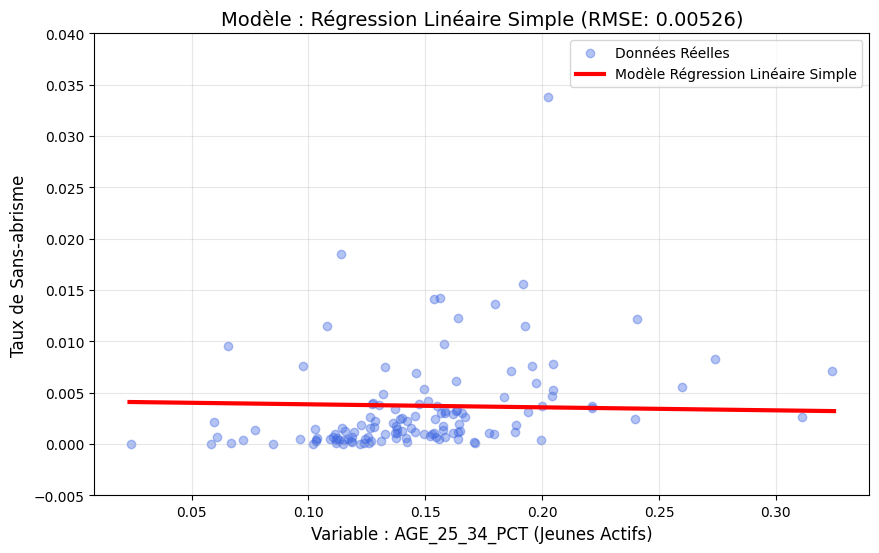

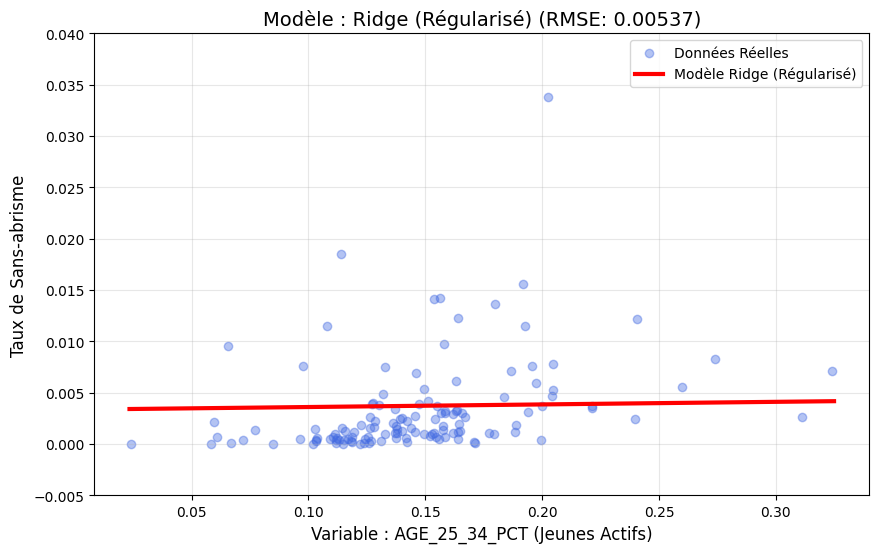

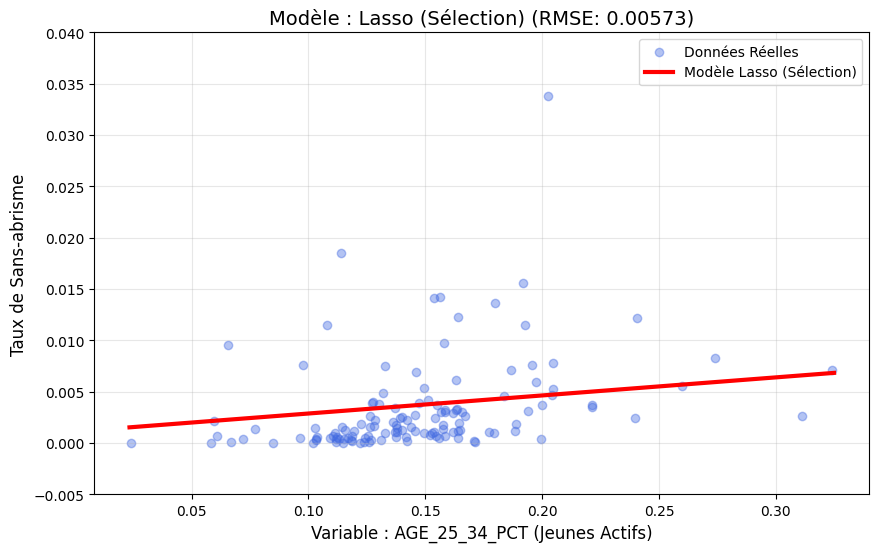

In [165]:

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV

# --- 1. PRÉPARATION ---
train = pd.read_csv('train.csv')

# On choisit la variable la plus impactante pour l'axe X (pour la visualisation 2D)
feature_visu = 'AGE_25_34_PCT' 

X = train.drop(columns=['ID', 'HOMELESS_RATE'])
y = train['HOMELESS_RATE']

# Standardisation (Obligatoire)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# --- 2. ENTRAÎNEMENT ---
# On entraîne les 3 modèles sur TOUTES les variables
lr = LinearRegression().fit(X_scaled_df, y)
ridge = RidgeCV(alphas=[0.1, 1.0, 10.0]).fit(X_scaled_df, y)
lasso = LassoCV(n_alphas=100).fit(X_scaled_df, y)

# --- 3. CRÉATION DE LA LIGNE DE TENDANCE (SIMULATION) ---
# Pour tracer une ligne en 2D alors qu'on a 30 dimensions, on fixe les autres variables à leur moyenne
# On crée 100 points qui vont du min au max de la variable choisie
x_range = np.linspace(X_scaled_df[feature_visu].min(), X_scaled_df[feature_visu].max(), 100)

# On crée un faux dataset où tout est moyen, sauf notre variable visu qui varie
X_simule = pd.DataFrame(np.zeros((100, X.shape[1])), columns=X.columns) # Tout à zéro (car moyenne après scaling = 0)
X_simule[feature_visu] = x_range # On fait varier juste la variable d'intérêt

# On demande aux modèles de prédire pour cette ligne
y_pred_lr = lr.predict(X_simule)
y_pred_ridge = ridge.predict(X_simule)
y_pred_lasso = lasso.predict(X_simule)

# On remet l'axe X à l'échelle réelle pour le graphique (plus lisible)
x_reel = x_range * X[feature_visu].std() + X[feature_visu].mean()


# --- 4. AFFICHAGE DES 3 GRAPHIQUES SÉPARÉS ---

# FONCTION D'AFFICHAGE POUR NE PAS RÉPÉTER LE CODE
def afficher_graphe(titre, y_pred_model, score_rmse):
    plt.figure(figsize=(10, 6))
    
    # 1. Les Points Fixes (Données Réelles)
    plt.scatter(train[feature_visu], y, color='royalblue', alpha=0.4, label='Données Réelles')
    
    # 2. La Ligne Changeante (Le Modèle)
    plt.plot(x_reel, y_pred_model, color='red', linewidth=3, label=f'Modèle {titre}')
    
    plt.title(f'Modèle : {titre} (RMSE: {score_rmse:.5f})', fontsize=14)
    plt.xlabel(f'Variable : {feature_visu} (Jeunes Actifs)', fontsize=12)
    plt.ylabel('Taux de Sans-abrisme', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # On force la même échelle pour bien comparer
    plt.ylim(-0.005, 0.04) 
    plt.show()

# GRAPHIQUE 1 : LINEAR REGRESSION
# Calcul rapide du RMSE sur le train pour l'affichage
rmse_lr = np.sqrt(((y - lr.predict(X_scaled_df)) ** 2).mean())
afficher_graphe("Régression Linéaire Simple", y_pred_lr, rmse_lr)

# GRAPHIQUE 2 : RIDGE (Le Meilleur)
rmse_ridge = np.sqrt(((y - ridge.predict(X_scaled_df)) ** 2).mean())
afficher_graphe("Ridge (Régularisé)", y_pred_ridge, rmse_ridge)

# GRAPHIQUE 3 : LASSO (Le Sélectif)
rmse_lasso = np.sqrt(((y - lasso.predict(X_scaled_df)) ** 2).mean())
afficher_graphe("Lasso (Sélection)", y_pred_lasso, rmse_lasso)

## ======= PARTIE 10: ENTRAÎNEMENT SUR TOUT LE TRAIN ET PRÉDICTION ========

In [166]:
print("=" * 50)
print("ENTRAÎNEMENT FINAL ET PRÉDICTION SUR LE TEST")
print("=" * 50)

# Sélectionner le meilleur modèle
if best_model_name == 'Linear Regression':
    final_model = LinearRegression()
elif best_model_name == 'Ridge Regression':
    final_model = Ridge(alpha=ridge_grid.best_params_['alpha'], random_state=42)
else:  # Lasso
    final_model = Lasso(alpha=lasso_grid.best_params_['alpha'], random_state=42, max_iter=10000)

# Entraîner sur toutes les données d'entraînement
print(f"Entraînement du modèle {best_model_name} sur tout le dataset train...")
final_model.fit(X_train_scaled_df, y_train)

# Faire des prédictions sur le test
print("Prédiction sur le dataset test...")
y_test_pred = final_model.predict(X_test_scaled_df)

# Créer un DataFrame pour les prédictions
predictions_df = pd.DataFrame({
    'ID': test_df['ID'],
    'HOMELESS_RATE_PRED': y_test_pred
})

# Sauvegarder les prédictions
predictions_df.to_csv('predictions_1.csv', index=False)
print(f"Prédictions sauvegardées dans 'predictions_1.csv'")
print(f"Shape des prédictions: {predictions_df.shape}")

ENTRAÎNEMENT FINAL ET PRÉDICTION SUR LE TEST
Entraînement du modèle Ridge Regression sur tout le dataset train...
Prédiction sur le dataset test...
Prédictions sauvegardées dans 'predictions_1.csv'
Shape des prédictions: (56, 2)


# === PARTIE 11: ANALYSE DES COEFFICIENTS ====

In [167]:
print("\n" + "=" * 50)
print("ANALYSE DES COEFFICIENTS DU MEILLEUR MODÈLE")
print("=" * 50)

# Créer un DataFrame avec les coefficients
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': final_model.coef_
})

# Trier par valeur absolue des coefficients
coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)

print("\nTop 10 des features les plus importantes:")
print(coef_df.head(10)[['Feature', 'Coefficient']].to_string(index=False))

print("\nBottom 10 des features les moins importantes:")
print(coef_df.tail(10)[['Feature', 'Coefficient']].to_string(index=False))

# Sauvegarder tous les coefficients
coef_df.to_csv('coefficients_1.csv', index=False)
print(f"\nCoefficients sauvegardés dans 'coefficients_1.csv'")


ANALYSE DES COEFFICIENTS DU MEILLEUR MODÈLE

Top 10 des features les plus importantes:
                    Feature  Coefficient
              AGE_25_34_PCT     0.000222
       TOTAL_HOUSEHOLDS_PCT    -0.000209
         NONVETERAN_POP_PCT     0.000204
   FAMILY_HH_CHILD_LT18_PCT    -0.000199
FAMILY_MEMBERS_UNDER_18_PCT    -0.000172
                AGE_U18_PCT    -0.000172
            FAMILY_HH_TOTAL    -0.000168
              AGE_35_44_PCT     0.000143
              AGE_55_59_PCT    -0.000134
            VETERAN_POP_PCT    -0.000120

Bottom 10 des features les moins importantes:
                            Feature  Coefficient
                      AGE_62_64_PCT    -0.000029
                  RACE_ASIAN_NH_PCT     0.000023
        NONFAMILY_SINGLE_FEMALE_PCT     0.000020
INDIVIDUALS_NOT_IN_FAMILY_UNITS_PCT     0.000020
      MULTI_PERSON_NONFAMILY_HH_PCT    -0.000018
                      AGE_18_24_PCT     0.000013
              RACE_HISPANIC_ANY_PCT     0.000007
                RACE_P

## ==== PARTIE 12: CROSS-VALIDATION FINALE ====


In [168]:
print("\n" + "=" * 50)
print("CROSS-VALIDATION FINALE SUR TOUT LE TRAIN")
print("=" * 50)

# Évaluer avec cross-validation
cv_scores = cross_val_score(
    final_model, 
    X_train_scaled_df, 
    y_train, 
    cv=5, 
    scoring='neg_root_mean_squared_error'
)

print(f"Scores RMSE (cross-validation): {-cv_scores}")
print(f"Moyenne RMSE: {-cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")




CROSS-VALIDATION FINALE SUR TOUT LE TRAIN
Scores RMSE (cross-validation): [0.00280927 0.01077826 0.00336932 0.00450915 0.00692825]
Moyenne RMSE: 0.0057 (+/- 0.0058)


#  ==== PARTIE 13: (RANDOM FOREST) ====

In [169]:
from sklearn.ensemble import RandomForestRegressor

# Configuration du modèle Random Forest
# On utilise max_depth=3 pour éviter le sur-apprentissage sur 130 lignes
rf_model = RandomForestRegressor(
    n_estimators=100, 
    max_depth=3, 
    random_state=42
)

# Entraînement sur les données déjà préparées (Partie 4)
rf_model.fit(X_train_scaled_df, y_train)

# Calcul des performances pour validation
y_train_pred_rf = rf_model.predict(X_train_scaled_df)
rmse_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
r2_rf = r2_score(y_train, y_train_pred_rf)

print(f"Random Forest - RMSE Entraînement: {rmse_rf:.4f}")
print(f"Random Forest - R² Entraînement: {r2_rf:.4f}")

Random Forest - RMSE Entraînement: 0.0036
Random Forest - R² Entraînement: 0.7095


# ======= Visualisation =======

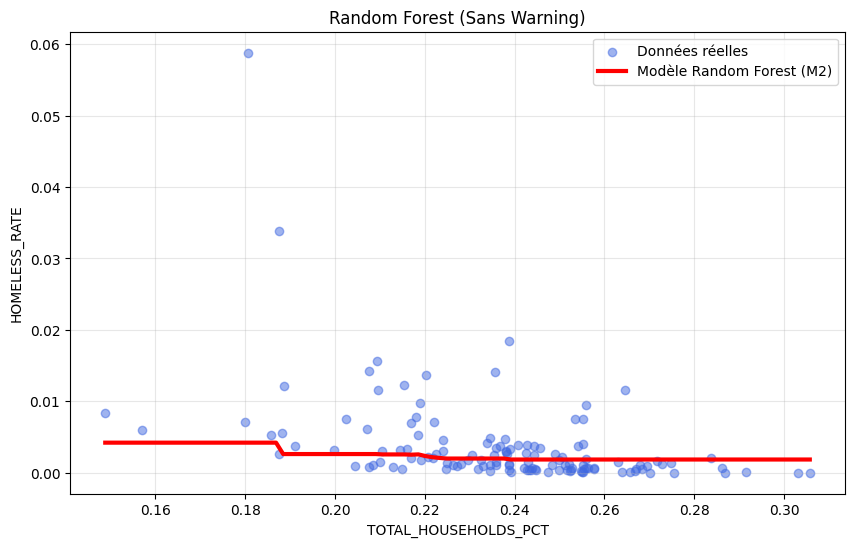

Modèle Random Forest entraîné sur l'ensemble des variables.
 Fichier 'submission_Random_forest.csv' généré avec succès !


In [170]:
# 2. Visualisation de la tendance non-linéaire (Livrable graphique)
plt.figure(figsize=(10, 6))

# Affichage des points réels
plt.scatter(train_df['TOTAL_HOUSEHOLDS_PCT'], y_train, color='royalblue', alpha=0.5, label='Données réelles')

# Pour tracer la courbe rouge conforme, on crée un dataset de simulation 
# avec les 31 colonnes pour que le modèle puisse prédire
x_range = np.linspace(train_df['TOTAL_HOUSEHOLDS_PCT'].min(), train_df['TOTAL_HOUSEHOLDS_PCT'].max(), 100)
x_simule = pd.DataFrame(np.tile(X_train_scaled_df.mean().values, (100, 1)), columns=X_train_scaled_df.columns)

# Mis à jour de la colonne cible pour la courbe
col_name = 'TOTAL_HOUSEHOLDS_PCT'
# Standardisation de x_range pour correspondre au modèle
x_simule[col_name] = (x_range - train_df[col_name].mean()) / train_df[col_name].std()

# Prédiction de la courbe
y_range_pred = rf_model.predict(x_simule)

# Affichage de la ligne rouge (Tendance)
plt.plot(x_range, y_range_pred, color='red', linewidth=3, label='Modèle Random Forest (M2)')

plt.title('Random Forest (Sans Warning)')
plt.xlabel('TOTAL_HOUSEHOLDS_PCT')
plt.ylabel('HOMELESS_RATE')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 3. Génération du fichier de soumission conforme
# On utilise X_test_scaled_df (déjà préparé en partie 4)
test_preds_rf = rf_model.predict(X_test_scaled_df)

submission_m2 = pd.DataFrame({
    'ID': test_df['ID'],
    'HOMELESS_RATE': test_preds_rf
})

submission_m2.to_csv('submission_Random_forest.csv', index=False)

print("Modèle Random Forest entraîné sur l'ensemble des variables.")
print(" Fichier 'submission_Random_forest.csv' généré avec succès !")
print("=" * 50)

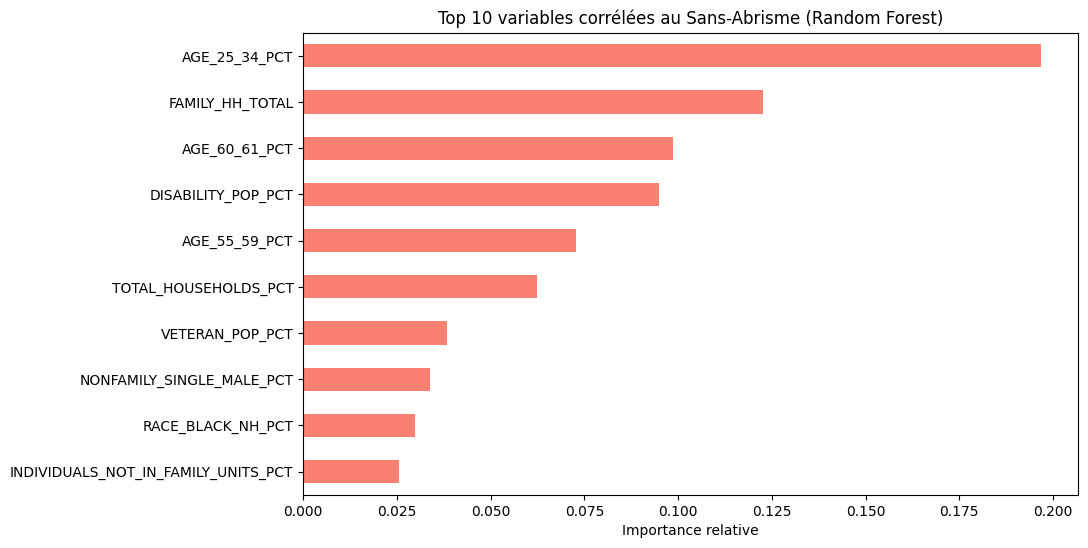

In [171]:
# Analyser quelles variables ont le plus d'impact pour votre modèle
importances = pd.Series(rf_model.feature_importances_, index=features)
importances_top10 = importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
importances_top10.plot(kind='barh', color='salmon')

plt.title('Top 10 variables corrélées au Sans-Abrisme (Random Forest)')
# -------------------------

plt.xlabel('Importance relative')
plt.gca().invert_yaxis() # Pour avoir la plus importante en haut
plt.show()

In [172]:
import joblib

# Sauvegarder votre modèle expert
joblib.dump(rf_model, 'modele_foret.pkl')
print(" Modèle sauvegardé sous le nom 'modele_foret.pkl'")

 Modèle sauvegardé sous le nom 'modele_foret.pkl'


In [173]:
import pandas as pd
import os
path = os.getcwd() + '/train.csv'
df = pd.read_csv(path)

In [174]:
df.head()

,ID,HOMELESS_RATE,AGE_U18_PCT,AGE_18_24_PCT,AGE_25_34_PCT,AGE_35_44_PCT,AGE_45_54_PCT,AGE_55_59_PCT,AGE_60_61_PCT,AGE_62_64_PCT,...,NONVETERAN_POP_PCT,DISABILITY_POP_PCT,NODISABILITY_POP_PCT,TOTAL_HOUSEHOLDS_PCT,FAMILY_HH_TOTAL,FAMILY_HH_CHILD_LT18_PCT,NONFAMILY_SINGLE_MALE_PCT,NONFAMILY_SINGLE_FEMALE_PCT,MULTI_PERSON_NONFAMILY_HH_PCT,INDIVIDUALS_NOT_IN_FAMILY_UNITS_PCT
0,SC_05,0.000000,0.388210,0.054130,0.058164,0.061302,0.161269,0.062087,0.037431,0.051104,...,0.771265,0.460607,0.020397,0.305727,0.251373,0.076544,0.174829,0.054354,0.021966,0.054354
1,RV_08,0.000999,0.368737,0.089002,0.132744,0.137555,0.156465,0.082081,0.031715,0.035453,...,0.766820,0.457923,0.023203,0.227111,0.184183,0.064947,0.119236,0.042928,0.016283,0.042928
2,SC_10,0.004736,0.429991,0.071720,0.204073,0.176398,0.127522,0.046399,0.020886,0.025102,...,0.767663,0.517711,0.030974,0.237949,0.198297,0.094440,0.103857,0.039651,0.014248,0.039651
3,AL_12,0.001269,0.476342,0.058899,0.115471,0.156583,0.147944,0.064417,0.027537,0.032103,...,0.731965,0.498431,0.023747,0.272830,0.234998,0.118750,0.116247,0.037832,0.013240,0.037832
4,SAC_04,0.000394,0.513634,0.078841,0.112881,0.145494,0.148405,0.066102,0.024644,0.029827,...,0.700749,0.485158,0.029264,0.249969,0.189581,0.093464,0.096118,0.060387,0.016156,0.060387


Les jeunes adultes ont souvent une situation professionnelle instable et peuvent être plus exposés à la précarité.
On regroupe les tranches 18–24 et 25–34 ans.

In [175]:
df["JEUNES_PCT"] = df["AGE_18_24_PCT"] + df["AGE_25_34_PCT"]

Les personnes âgées peuvent être plus vulnérables économiquement et socialement.
On regroupe toutes les tranches de plus de 65 ans.

In [176]:
df["SENIORS_PCT"] = (
    df["AGE_65_69_PCT"] +
    df["AGE_70_79_PCT"] +
    df["AGE_80_PLUS_PCT"]
)

On veut représenter la population généralement en activité professionnelle.
On additionne les tranches 35–44, 45–54 et 55–59 ans.

In [177]:
df["ACTIFS_PCT"] = (
    df["AGE_35_44_PCT"] +
    df["AGE_45_54_PCT"] +
    df["AGE_55_59_PCT"]
)

Vivre seul peut influencer le niveau de précarité ou l’accès aux ressources. on additionner les pourcentages d’hommes et femmes vivant seuls.

In [178]:
df["Single_PCT"] = (
    df["NONFAMILY_SINGLE_MALE_PCT"] +
    df["NONFAMILY_SINGLE_FEMALE_PCT"]
)

Les personnes vivant seules ou dans des ménages non familiaux peuvent être plus isolées socialement ce qui peut avoir un impact sur le bien-être, l’accès à l’emploi, la santé ou la précarité.

In [179]:
df['social_isolation'] = (
        df['INDIVIDUALS_NOT_IN_FAMILY_UNITS_PCT'] + 
        df['MULTI_PERSON_NONFAMILY_HH_PCT']
    )

Pour comprendre la diversité et certaines inégalités sociales dans certains regions. On calcule le complément du pourcentage de population blanche.

In [180]:
df["NON_WHITE_PCT"] = 1 - df["RACE_WHITE_NH_PCT"]

In [181]:
df.head()

,ID,HOMELESS_RATE,AGE_U18_PCT,AGE_18_24_PCT,AGE_25_34_PCT,AGE_35_44_PCT,AGE_45_54_PCT,AGE_55_59_PCT,AGE_60_61_PCT,AGE_62_64_PCT,...,NONFAMILY_SINGLE_MALE_PCT,NONFAMILY_SINGLE_FEMALE_PCT,MULTI_PERSON_NONFAMILY_HH_PCT,INDIVIDUALS_NOT_IN_FAMILY_UNITS_PCT,JEUNES_PCT,SENIORS_PCT,ACTIFS_PCT,Single_PCT,social_isolation,NON_WHITE_PCT
0,SC_05,0.000000,0.388210,0.054130,0.058164,0.061302,0.161269,0.062087,0.037431,0.051104,...,0.174829,0.054354,0.021966,0.054354,0.112294,0.640816,0.284658,0.229183,0.076320,0.478427
1,RV_08,0.000999,0.368737,0.089002,0.132744,0.137555,0.156465,0.082081,0.031715,0.035453,...,0.119236,0.042928,0.016283,0.042928,0.221745,0.301236,0.376101,0.162164,0.059211,0.500148
2,SC_10,0.004736,0.429991,0.071720,0.204073,0.176398,0.127522,0.046399,0.020886,0.025102,...,0.103857,0.039651,0.014248,0.039651,0.275793,0.225808,0.350319,0.143508,0.053899,0.596206
3,AL_12,0.001269,0.476342,0.058899,0.115471,0.156583,0.147944,0.064417,0.027537,0.032103,...,0.116247,0.037832,0.013240,0.037832,0.174371,0.317749,0.368944,0.154079,0.051072,0.578432
4,SAC_04,0.000394,0.513634,0.078841,0.112881,0.145494,0.148405,0.066102,0.024644,0.029827,...,0.096118,0.060387,0.016156,0.060387,0.191722,0.273975,0.360002,0.156505,0.076544,0.676236


# ========Feature Selection========

In [182]:
# === BLOC 1 : PRÉPARATION DES DONNÉES COMPLÈTES ===
df_complet = df.copy()  # ou train_df si c'est le nom utilisé

X = df_complet.drop(columns=['ID', 'HOMELESS_RATE'])
y = df_complet['HOMELESS_RATE']

print(f"Nombre total de variables à trier : {X.shape[1]}")

Nombre total de variables à trier : 37


# ==========Le Grand Nettoyage==========
Certaines variables disent exactement la même chose (ex: AGE_U18_PCT et FAMILY_MEMBERS_UNDER_18_PCT sont presque identiques). Garder les deux embrouille le modèle linéaire. on vas supprimer les "doublons".

In [183]:
# === BLOC 2 : SUPPRESSION DES DOUBLONS (CORRÉLATION) ===
# On calcule la matrice de corrélation
corr_matrix = X.corr().abs()

# On sélectionne le triangle supérieur de la matrice
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# On cherche les colonnes qui ont une corrélation > 0.95 (quasi identiques)
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

print(f"Variables trop corrélées à supprimer ({len(to_drop)}) :")
print(to_drop)

# On les supprime
X_reduced = X.drop(columns=to_drop)
print(f"Reste : {X_reduced.shape[1]} variables")

Variables trop corrélées à supprimer (6) :
['AGE_25_PLUS_PCT', 'FAMILY_MEMBERS_UNDER_18_PCT', 'INDIVIDUALS_NOT_IN_FAMILY_UNITS_PCT', 'SENIORS_PCT', 'social_isolation', 'NON_WHITE_PCT']
Reste : 31 variables


# =====La Sélection d'Élite=====


In [184]:
# === BLOC 3 : SÉLECTION AUTOMATIQUE RFE (Recursive Feature Elimination)===
from sklearn.feature_selection import RFE
from sklearn.linear_model import Ridge

# On standardise (Important pour que Ridge juge équitablement)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reduced)

# Le juge : Un modèle Ridge
model_selector = Ridge(alpha=1.0)

# La méthode : On veut garder les 15 meilleures
rfe = RFE(estimator=model_selector, n_features_to_select=15)
rfe.fit(X_scaled, y)

# On récupère les noms des gagnantes
selected_cols = X_reduced.columns[rfe.support_]

print("\n Top 15 variables :")
print(selected_cols.tolist())


 Top 15 variables :
['AGE_35_44_PCT', 'AGE_55_59_PCT', 'AGE_65_69_PCT', 'AGE_70_79_PCT', 'AGE_80_PLUS_PCT', 'RACE_WHITE_NH_PCT', 'RACE_BLACK_NH_PCT', 'RACE_TWO_OR_MORE_NH_PCT', 'VETERAN_POP_PCT', 'DISABILITY_POP_PCT', 'FAMILY_HH_TOTAL', 'FAMILY_HH_CHILD_LT18_PCT', 'NONFAMILY_SINGLE_MALE_PCT', 'MULTI_PERSON_NONFAMILY_HH_PCT', 'Single_PCT']


# ======SAUVEGARDE DE LA LISTE======


In [185]:
import joblib

# On sauvegarde la liste des colonnes dans un fichier
joblib.dump(selected_cols.tolist(), 'features_selectionnees.pkl')

print("Liste des meilleures variables sauvegardée !")

Liste des meilleures variables sauvegardée !


# ÉTAPE FINALE : GÉNÉRATION DE LA SOUMISSION

In [186]:
print("\n" + "="*50)
print("ÉTAPE FINALE : GÉNÉRATION DE LA SOUMISSION")
print("="*50)

# 1. CHARGEMENT DES DONNÉES DE BASE
print("Chargement des fichiers originaux...")
train_final = pd.read_csv('train.csv')
test_final = pd.read_csv('test.csv')

# 2. APPLICATION DES CALCULS DU MEMBRE 4 (Copier-Coller des formules)
# On doit le faire sur TRAIN et sur TEST pour qu'ils aient les mêmes colonnes

for df in [train_final, test_final]:
    # Jeunesse
    if 'AGE_18_24_PCT' in df.columns:
        df["JEUNES_PCT"] = df["AGE_18_24_PCT"] + df["AGE_25_34_PCT"]
    # Seniors
    if 'AGE_65_69_PCT' in df.columns:
        df["SENIORS_PCT"] = df["AGE_65_69_PCT"] + df["AGE_70_79_PCT"] + df["AGE_80_PLUS_PCT"]
    # Actifs
    if 'AGE_35_44_PCT' in df.columns:
        df["ACTIFS_PCT"] = df["AGE_35_44_PCT"] + df["AGE_45_54_PCT"] + df["AGE_55_59_PCT"]
    # Isolement (Hommes seuls + Femmes seules)
    if 'NONFAMILY_SINGLE_MALE_PCT' in df.columns:
        df["Single_PCT"] = df["NONFAMILY_SINGLE_MALE_PCT"] + df["NONFAMILY_SINGLE_FEMALE_PCT"]
    # Isolation Sociale
    if 'INDIVIDUALS_NOT_IN_FAMILY_UNITS_PCT' in df.columns:
        df["social_isolation"] = df["INDIVIDUALS_NOT_IN_FAMILY_UNITS_PCT"] + df["MULTI_PERSON_NONFAMILY_HH_PCT"]
    # Minorités
    if 'RACE_WHITE_NH_PCT' in df.columns:
        df["NON_WHITE_PCT"] = 1 - df["RACE_WHITE_NH_PCT"]

print("Les nouvelles variables (Single_PCT, JEUNES_PCT...) ont été créées sur Train et Test.")

# 3. CHARGEMENT DE LA SÉLECTION DU FAHD (TOP 15)
nom_fichier_features = 'features_selectionnees_fahd.pkl' 

try:
    selected_features = joblib.load(nom_fichier_features)
    print(f"Liste des variables chargée : {len(selected_features)} variables.")
except FileNotFoundError:
    print(f"Fichier '{nom_fichier_features}' non trouvé.")
# 4. PRÉPARATION DES DONNÉES POUR L'IA
# On ne garde que les colonnes de la liste
X_train = train_final[selected_features]
y_train = train_final['HOMELESS_RATE']
X_test = test_final[selected_features]

# Standardisation (Obligatoire pour Ridge)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. ENTRAÎNEMENT FINAL (RidgeCV)
print("Entraînement du modèle final...")
model_final = RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0, 100.0, 1000.0], cv=5)
model_final.fit(X_train_scaled, y_train)

print(f"Modèle entraîné (Alpha: {model_final.alpha_})")
print(f"Score R² (Train) : {model_final.score(X_train_scaled, y_train):.4f}")

# 6. PRÉDICTION ET CRÉATION DU FICHIER CSV
y_pred = model_final.predict(X_test_scaled)
y_pred = np.maximum(y_pred, 0) # On remplace les négatifs par 0

submission = pd.DataFrame({
    'ID': test_final['ID'],
    'HOMELESS_RATE': y_pred
})

nom_fichier_sortie = 'submission_final_team.csv'
submission.to_csv(nom_fichier_sortie, index=False)

print("\n" + "="*50)
print(f"TERMINE ! Le fichier '{nom_fichier_sortie}' est prêt.")
print("="*50)


ÉTAPE FINALE : GÉNÉRATION DE LA SOUMISSION
Chargement des fichiers originaux...
Les nouvelles variables (Single_PCT, JEUNES_PCT...) ont été créées sur Train et Test.
Fichier 'features_selectionnees_fahd.pkl' non trouvé.
Entraînement du modèle final...
Modèle entraîné (Alpha: 100.0)
Score R² (Train) : 0.2691

TERMINE ! Le fichier 'submission_final_team.csv' est prêt.
